In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-product-reviews-sentiment-analysis/AmazonReview.csv


In [2]:
import matplotlib.pyplot as plt 
import re 
import seaborn as sns 
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import tensorflow as tf 
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, Embedding, BatchNormalization 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.utils import pad_sequences 

import warnings 
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('/kaggle/input/amazon-product-reviews-sentiment-analysis/AmazonReview.csv')

In [4]:
data.head()

,Review,Sentiment
0,Fast shipping but this product is very cheaply...,1
1,This case takes so long to ship and it's not e...,1
2,Good for not droids. Not good for iPhones. You...,1
3,The cable was not compatible between my macboo...,1
4,The case is nice but did not have a glow light...,1


In [5]:
data.shape

(25000, 2)

In [6]:
print("Null Values : ", data.isna().sum())

data = data.dropna()

print("Null Values : ", data.isna().sum())

Null Values :  Review       1
Sentiment    0
dtype: int64
Null Values :  Review       0
Sentiment    0
dtype: int64


In [7]:
data['Sentiment'].value_counts()

Sentiment
1    5000
2    5000
3    5000
4    5000
5    4999
Name: count, dtype: int64

# **EDA**

In [8]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt_tab') # Dataset for tokenizing 

stop_words = set(stopwords.words('english'))
# Stop words are common words like "the", "is", "and" that usually don't add much meaning to a sentence.

def clean_reviews(text): 
    if isinstance(text, str): 
        text = text.lower()  
        text = word_tokenize(text) 
        text = [word for word in text if word not in stop_words]  
    else:
        text = []  
    return text 

# Handle non-string values in the 'Review' column
data['Review'] = data['Review'].astype(str)  
data['Review'] = data['Review'].fillna('')   

# Apply the cleaning function
data['Review'] = data['Review'].apply(clean_reviews)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [9]:
data.head()

,Review,Sentiment
0,"[fast, shipping, product, cheaply, made, broug...",1
1,"[case, takes, long, ship, 's, even, worth, don...",1
2,"[good, droids, ., good, iphones, ., use, featu...",1
3,"[cable, compatible, macbook, iphone, ., also, ...",1
4,"[case, nice, glow, light, ., 'm, disappointed,...",1


In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer # Converts text into numbers
from tensorflow.keras.preprocessing.sequence import pad_sequences # Ensures all sequences have the same length by padding or truncating them
import numpy as np
import pandas as pd

tokenizer = Tokenizer() 

reviews_to_list = data['Review'].tolist() 
tokenizer.fit_on_texts(reviews_to_list) # analyzes the text and builds a vocabulary 

text_sequences = tokenizer.texts_to_sequences(reviews_to_list) # Each word in the text is replaced by its corresponding integer ID from the tokenizer's vocabulary

max_words = 500
X = pad_sequences(text_sequences, maxlen=max_words)

data = pd.get_dummies(data, columns=['Sentiment'])

y = data[['Sentiment_1', 'Sentiment_2', 'Sentiment_3', 'Sentiment_4', 'Sentiment_5']] 

print(X.shape, y.shape)

(24999, 500) (24999, 5)


# **Train-Test-Split**

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(19999, 500) (5000, 500) (19999, 5) (5000, 5)


# **RNN Model**

In [12]:
rnn = Sequential(name="Simple_RNN") 
rnn.add(Embedding(len(tokenizer.word_index)+1, 
						max_words, 
						input_length=max_words)) 

rnn.add(SimpleRNN(128,activation='relu',return_sequences=True)) 

rnn.add(SimpleRNN(64,activation='relu',return_sequences=False)) 

rnn.add(Dense(5, activation='softmax')) 

print(rnn.summary())

Model: "Simple_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [13]:
rnn.compile( 
	loss="categorical_crossentropy", 
	optimizer='adam', 
	metrics=['accuracy'] 
) 


history = rnn.fit(X_train, y_train, 
						batch_size=64, 
						epochs=3, #higher epochs causes overfitting because the model is too simple
						verbose=1, 
						validation_data = (X_test, y_test)) 


print("Simple_RNN Score---> ", rnn.evaluate(X_test, y_test, verbose=1))

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 114ms/step - accuracy: 0.3098 - loss: 1.4953 - val_accuracy: 0.4266 - val_loss: 1.2613
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 106ms/step - accuracy: 0.5198 - loss: 1.1147 - val_accuracy: 0.4360 - val_loss: 1.2824
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 105ms/step - accuracy: 0.6703 - loss: 0.8309 - val_accuracy: 0.4170 - val_loss: 1.4590
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.4197 - loss: 1.4589
Simple_RNN Score--->  [1.4590290784835815, 0.4169999957084656]


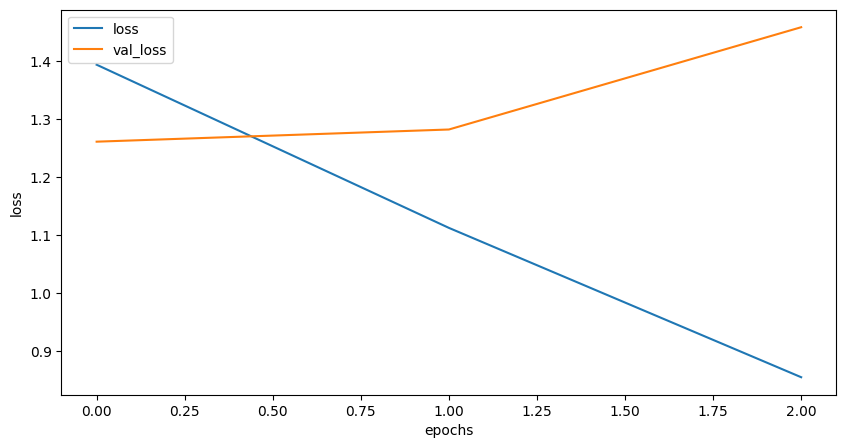

In [14]:
metrics = history.history

plt.figure(figsize = (10 , 5))
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['loss' , 'val_loss'])
plt.show()

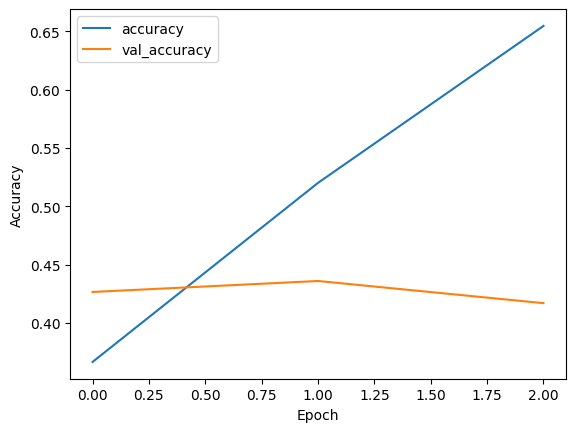

In [15]:
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# **LSTM Model**

In [16]:
model = Sequential(name="LSTM_Model") 
model.add(Embedding(len(tokenizer.word_index)+1, 
					max_words, 
					input_length=max_words)) 


model.add(LSTM(150, return_sequences=False)) 
BatchNormalization() 
model.add(Dropout(0.5)) 


model.add(Dense(50, activation='relu')) 
BatchNormalization() 
model.add(Dropout(0.5)) 


model.add(Dense(5, activation='softmax')) 
 
print(model.summary())

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [17]:
model.compile(
    loss="categorical_crossentropy", 
    optimizer='adam', 
    metrics=['accuracy']
)


history2 = model.fit(X_train, y_train, 
                    batch_size=64, 
                    epochs=3, 
                    verbose=1, 
                    validation_data=(X_test, y_test))


print("LSTM model Score---> ", model.evaluate(X_test, y_test, verbose=1))

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 58ms/step - accuracy: 0.3121 - loss: 1.4942 - val_accuracy: 0.4474 - val_loss: 1.2463
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.5056 - loss: 1.1482 - val_accuracy: 0.4642 - val_loss: 1.2207
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.6084 - loss: 0.9477 - val_accuracy: 0.4532 - val_loss: 1.3447
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4436 - loss: 1.3551
LSTM model Score--->  [1.344744086265564, 0.45320001244544983]


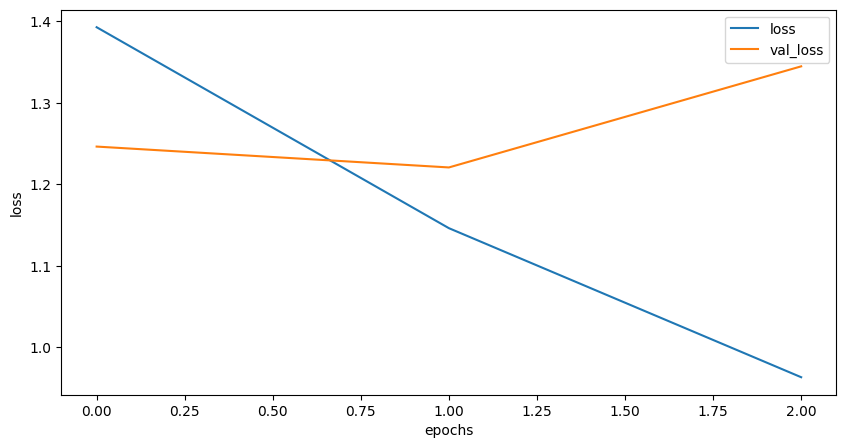

In [18]:
metrics = history2.history 

plt.figure(figsize=(10, 5)) 
plt.plot(history2.epoch, metrics['loss'], metrics['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['loss' , 'val_loss'])
plt.show()

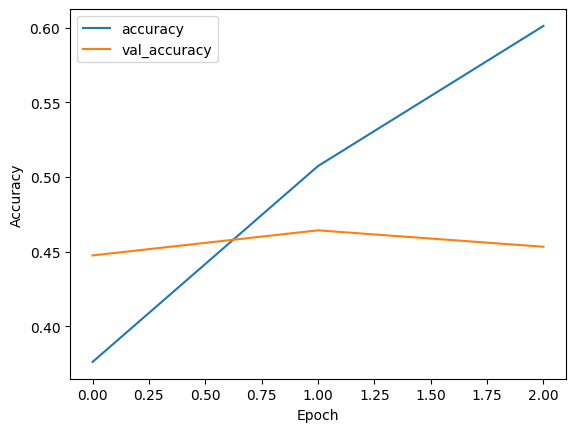

In [19]:
plt.plot(history2.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()